<a href="https://colab.research.google.com/github/mpiatek26/Bank_Customer_Segmentation/blob/main/Bank_Credit_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

Import dataset

In [42]:
data = pd.read_csv("german_credit_data.csv")

Look at dataset

In [43]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


Drop the column

In [44]:
data.drop(data.columns[0], inplace=True, axis=1)
print("Database has {} obserwations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))
print("Missing values in each column:\n{}".format(data.isnull().sum()))
print("Columns data types:\n{}".format(data.dtypes))

Database has 1000 obserwations (customers) and 9 columns (attributes).
Missing values in each column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Columns data types:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


In [45]:
n_unique = data.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [46]:
print("Unique values in each categorical column:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Unique values in each categorical column:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


Exploratory data analysis

In [47]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

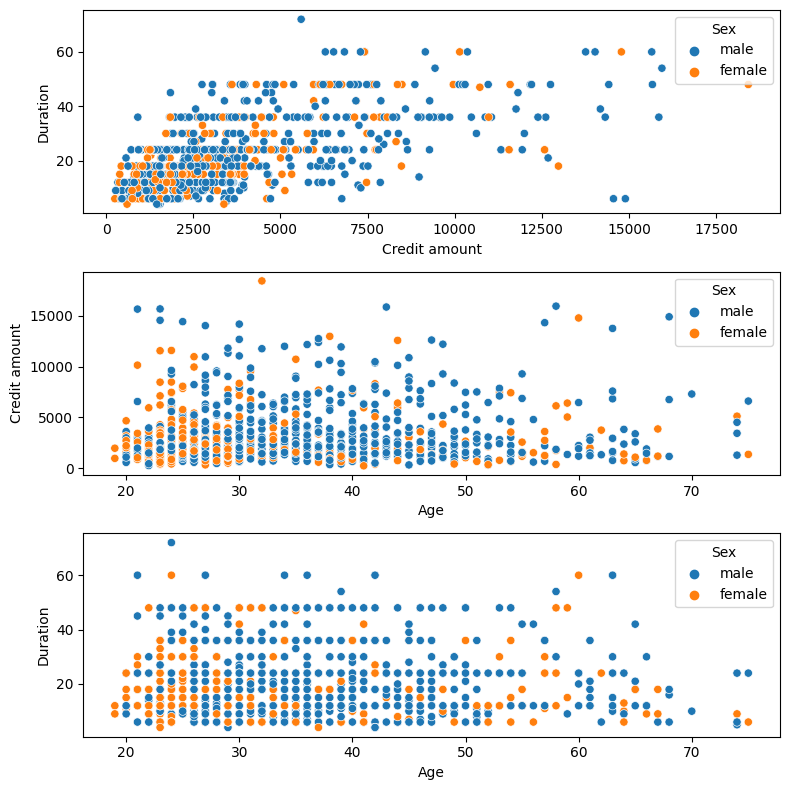

In [48]:
scatters(data, h="Sex")

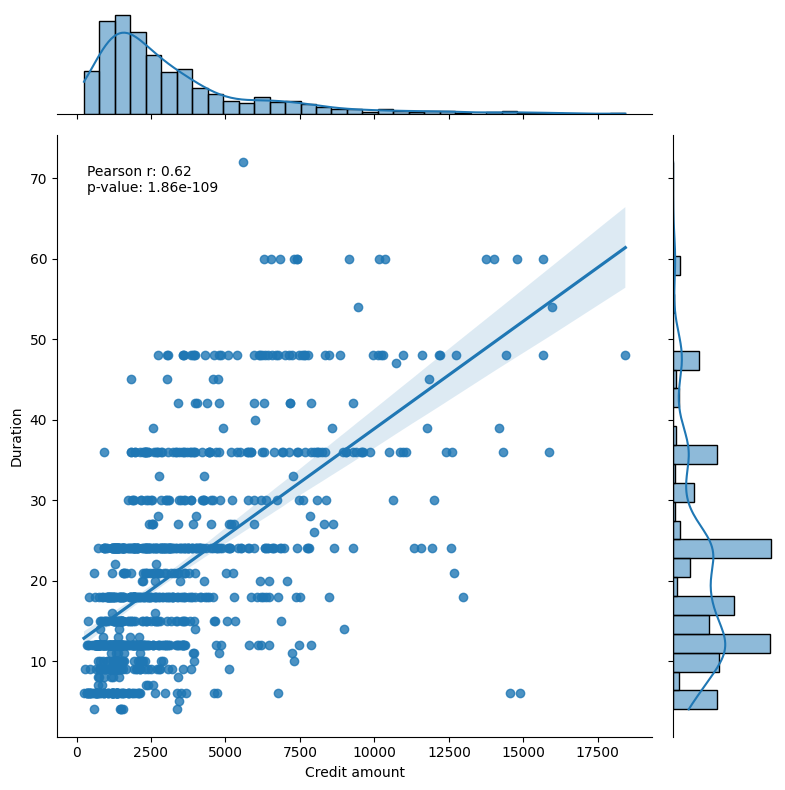

In [50]:
# check linear corelation
import scipy.stats as stats

# Creating the jointplot
r1 = sns.jointplot(x="Credit amount", y="Duration", data=data, kind="reg", height=8)

# Calculate the Pearson correlation and p-value
corr_value, p_value = stats.pearsonr(data['Credit amount'], data['Duration'])

# Add the annotation to the plot with correlation and p-value
r1.ax_joint.text(0.05, 0.95, f'Pearson r: {corr_value:.2f}\np-value: {p_value:.2e}',
                 transform=r1.ax_joint.transAxes, ha='left', va='top')

# Show the plot
plt.show()


Linear regression plots

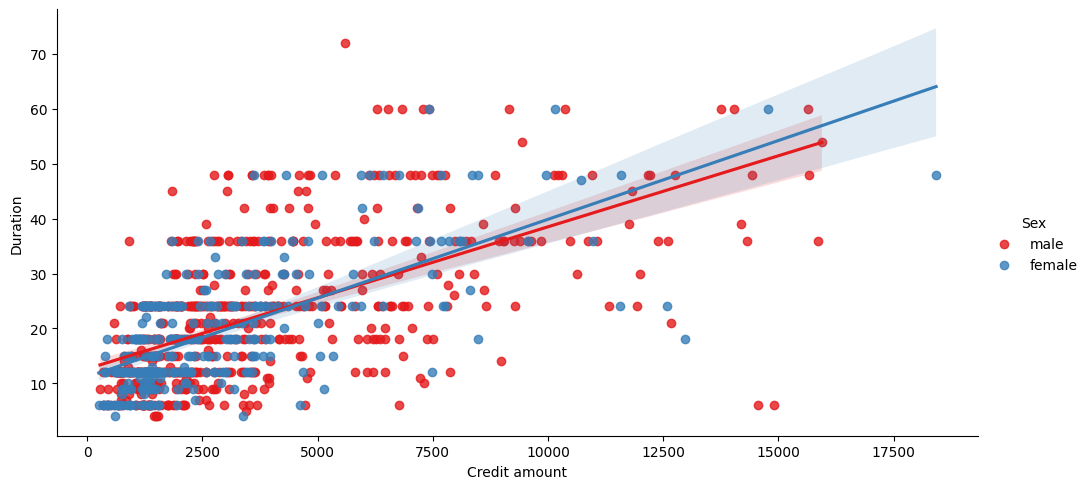

In [51]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.show()

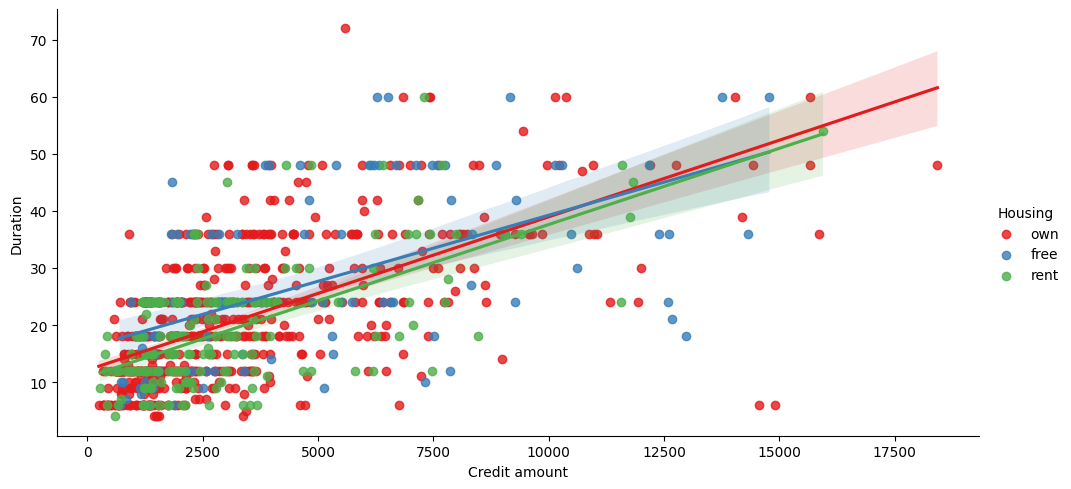

In [52]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.show()

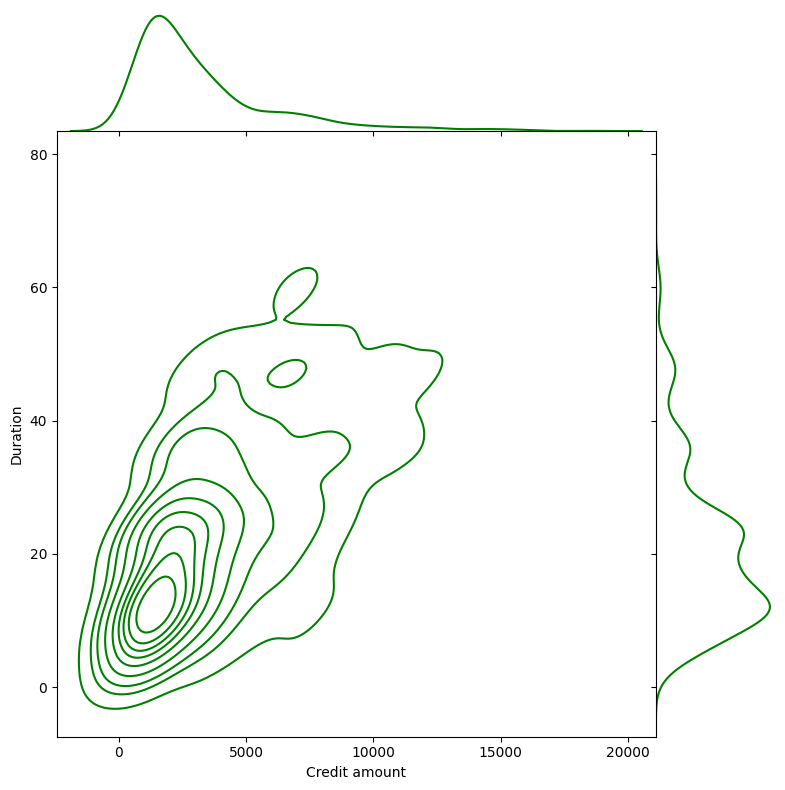

In [54]:
sns.jointplot(x="Credit amount", y="Duration", data=data, kind="kde", space=0, color="g", height=8)
plt.show()

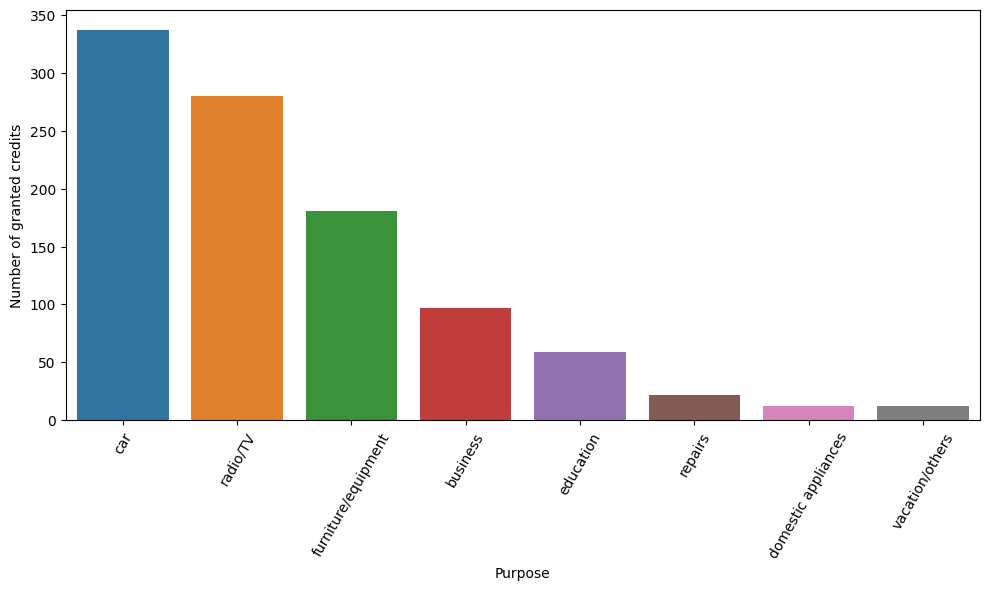

In [55]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.tight_layout()

In [56]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

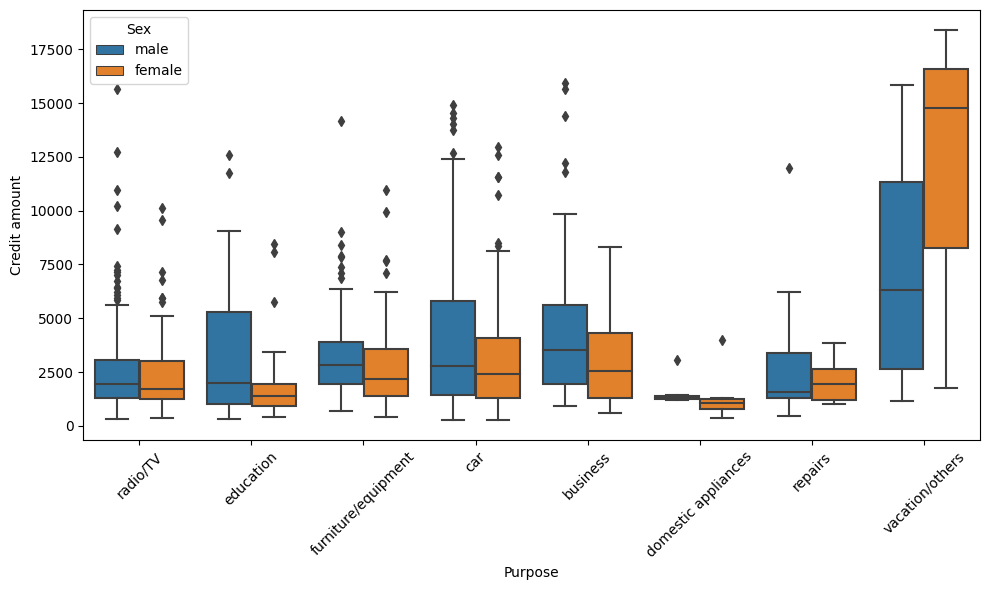

In [57]:
boxes("Purpose","Credit amount","Sex")

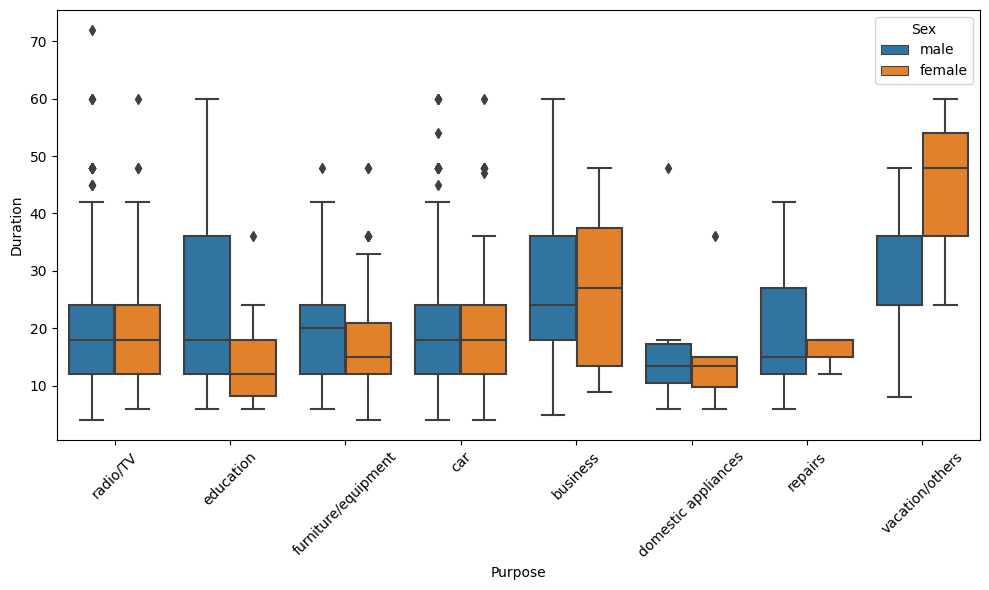

In [58]:
boxes("Purpose","Duration","Sex")

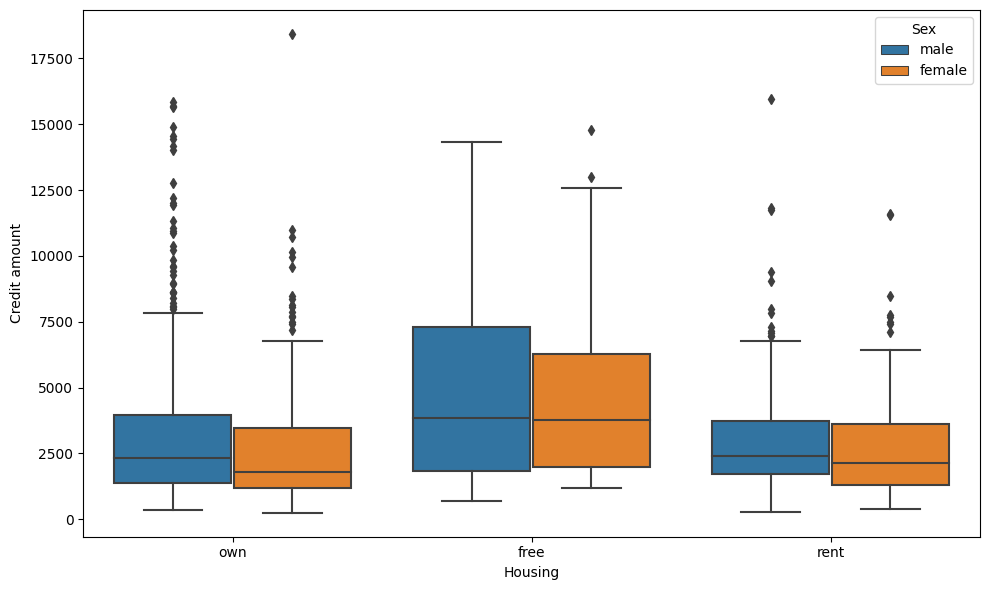

In [59]:
boxes("Housing","Credit amount","Sex",r=0)

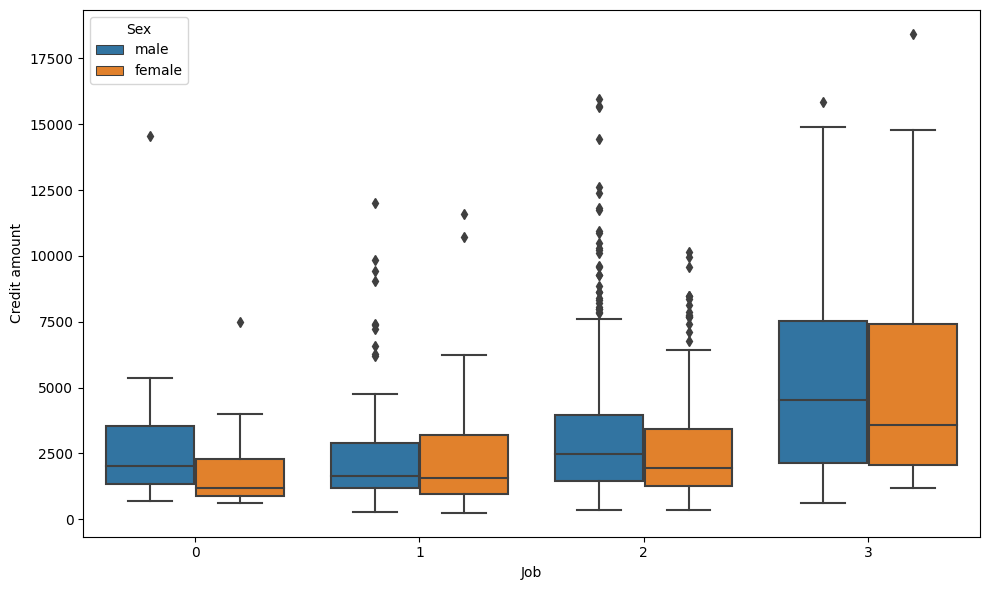

In [60]:
boxes("Job","Credit amount","Sex",r=0)

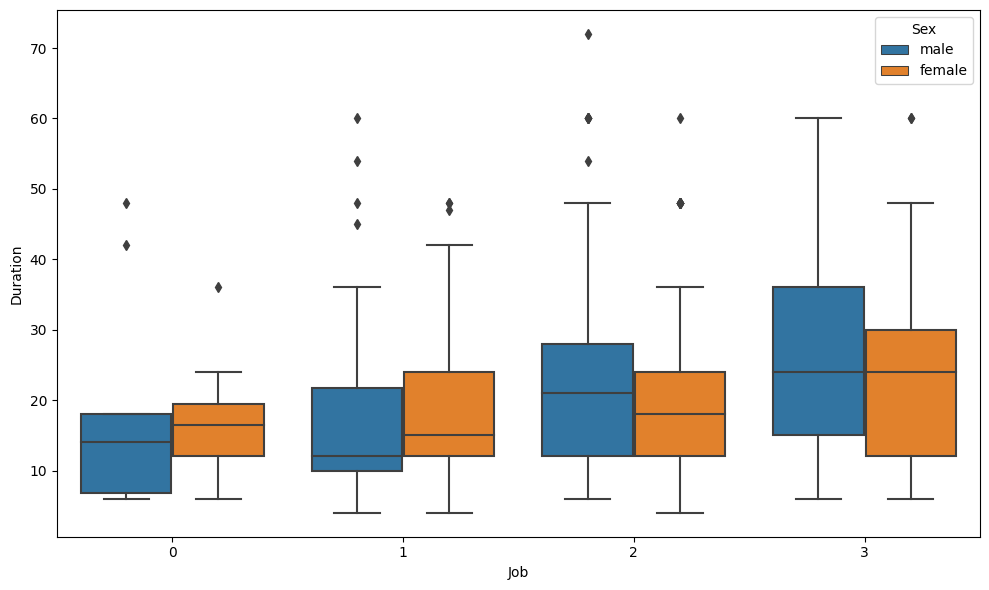

In [61]:
boxes("Job","Duration","Sex",r=0)

Text(0.5, 0, 'Age')

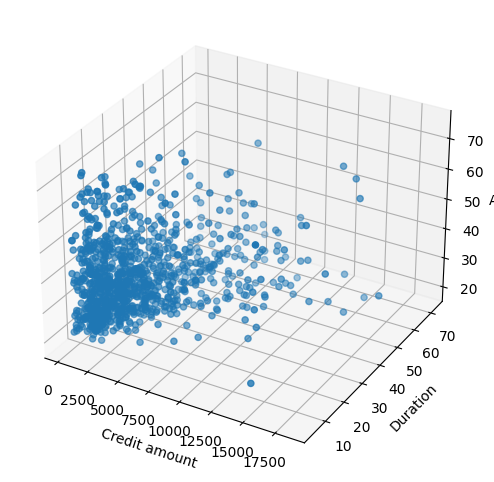

In [62]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

Clustering - KMeans

In [63]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

In [64]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

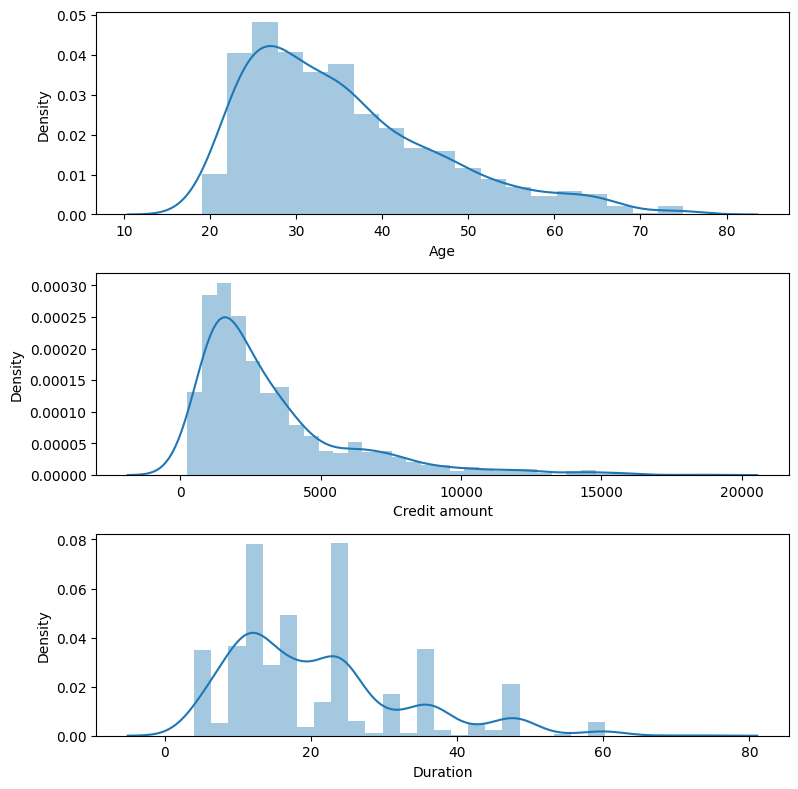

In [65]:
distributions(cluster_data)

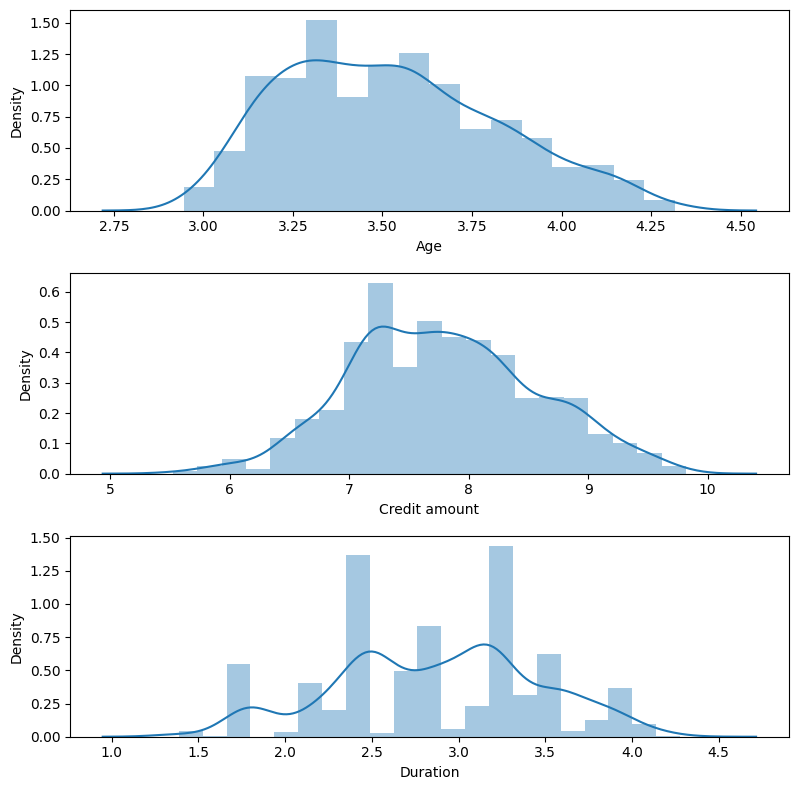

In [66]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

Center and scaling

In [67]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

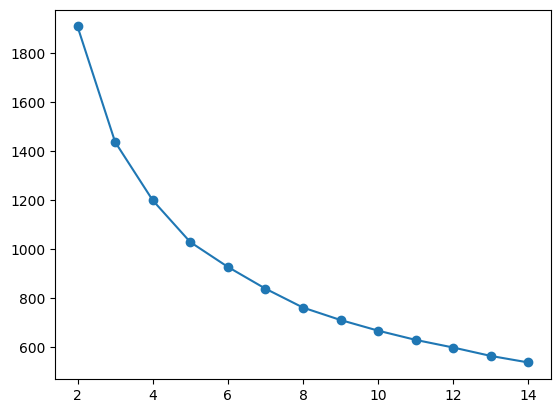

In [68]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

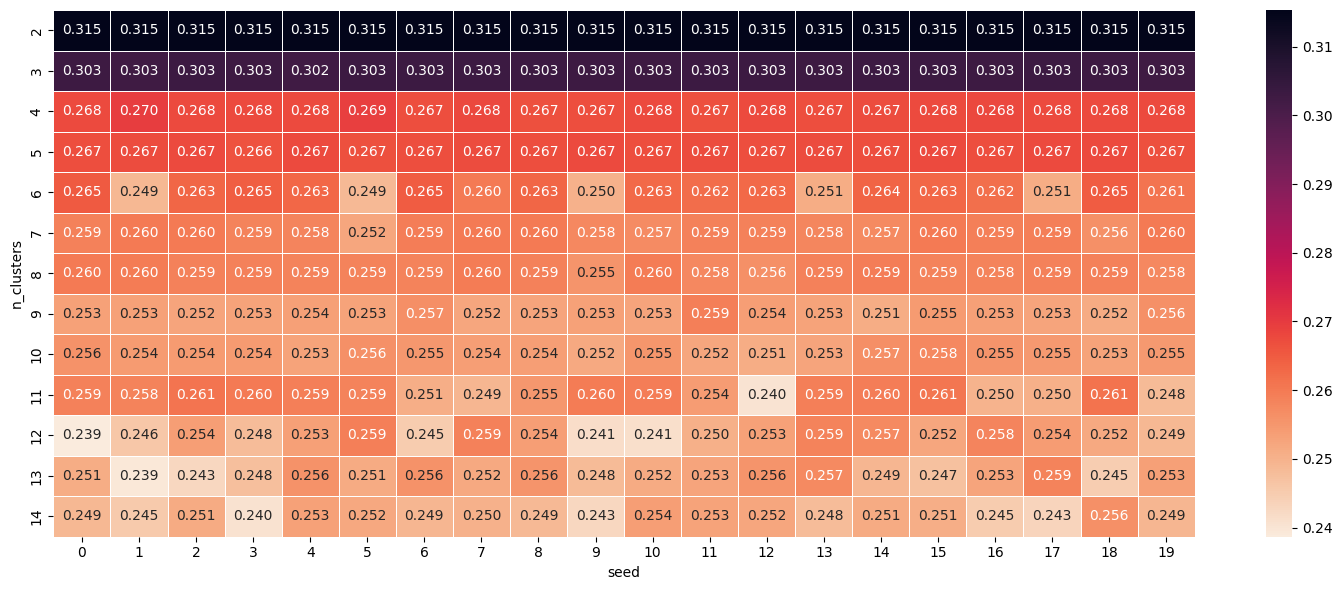

In [69]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

In [70]:
# choose 3 clusters
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

For n_clusters = 3  and seed = 19 
The average silhouette_score is : 0.30255813750380023


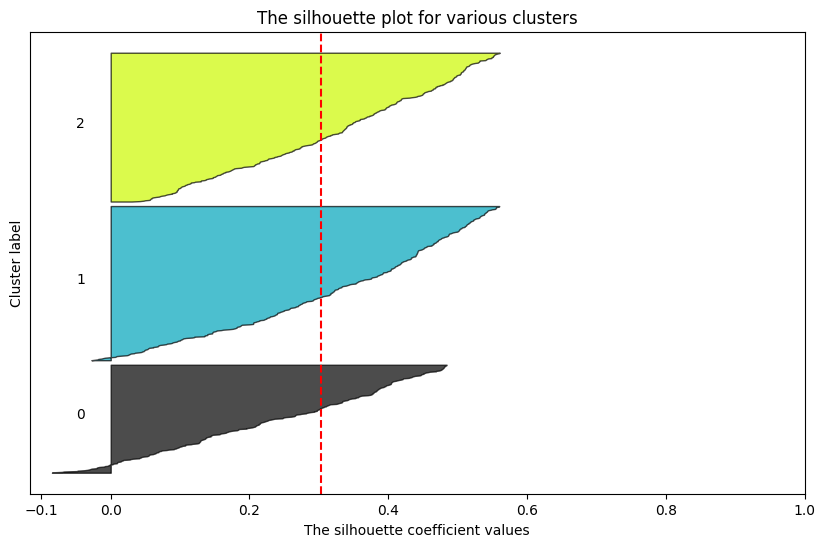

In [71]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

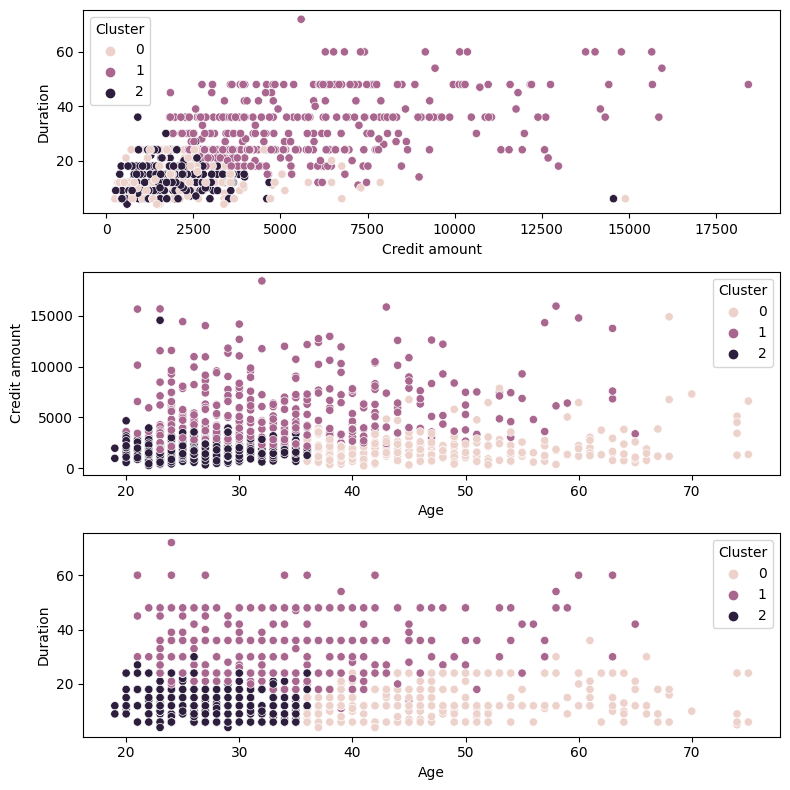

In [72]:
scatters(clustered_data, 'Cluster')

In [73]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,48.500,1970.300,13.900
1,34.000,5665.400,32.200
2,27.700,1736.300,14.300


Clustering with affinity propagation

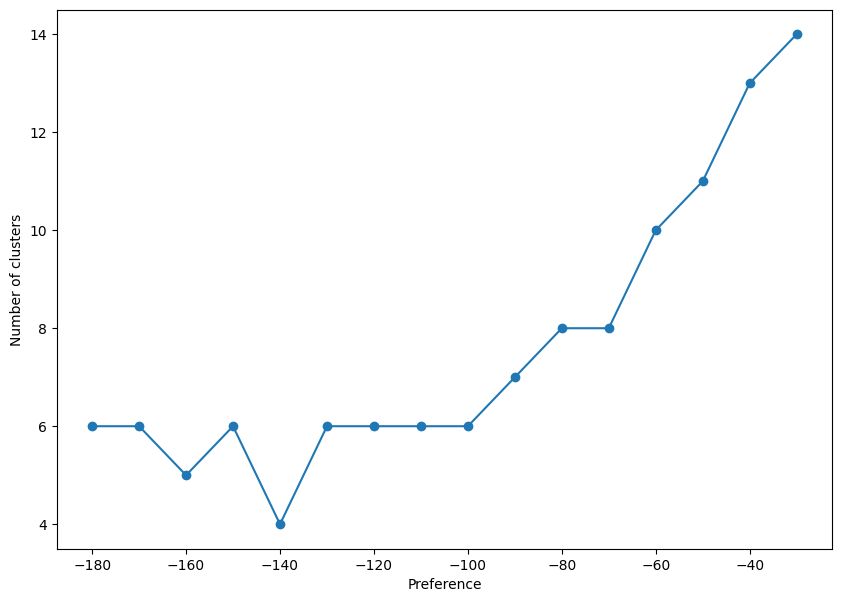

In [74]:
preferences = np.arange(-30,-190,-10)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')

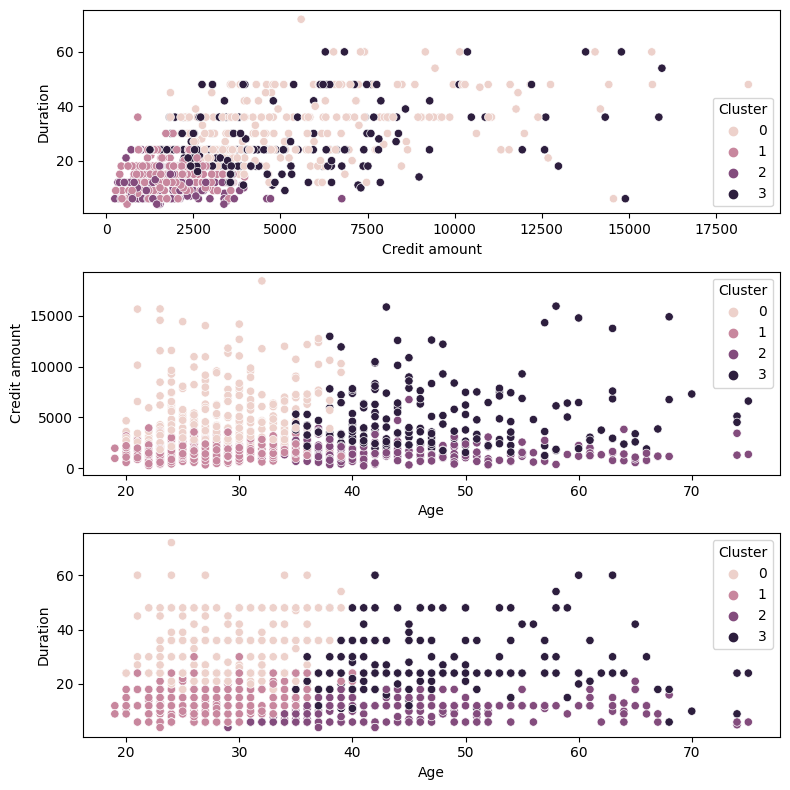

In [75]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)
scatters(clustered_data_af,'Cluster')

grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)

In [76]:
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)
grouped_af

,Age,Credit amount,Duration
Cluster,,,
0,28.700,5593.700,32.200
1,27.900,1654.300,15.100
2,46.000,1551.700,10.700
3,47.500,4977.900,27.600
